In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [165]:
import re

with open('wmo121000iso.txt', 'r', encoding='ISO-8859-2') as file:
    lines = file.readlines()[1:5000]

data = [re.split(r'\s+', line.strip()) for line in lines]

columns = [
    'N', 'M', 'D', 'H', 'DBT', 'RH', 'HR', 'WS', 'WD',
    'ITH', 'IDH', 'ISH', 'TSKY',
    'N_0', 'N_30', 'NE_30', 'E_30', 'SE_30', 'S_30', 'SW_30', 'W_30', 'NW_30',
    'N_45', 'NE_45', 'E_45', 'SE_45', 'S_45', 'SW_45', 'W_45', 'NW_45',
    'N_60', 'NE_60', 'E_60', 'SE_60', 'S_60', 'SW_60', 'W_60', 'NW_60',
    'N_90', 'NE_90', 'E_90', 'SE_90', 'S_90', 'SW_90', 'W_90', 'NW_90'
]

df = pd.DataFrame(data, columns=columns)
df = df.drop(index=0)
df = df.apply(pd.to_numeric, errors='coerce')

def calculate_date(row):
    total_hours = row['N'] - 1
    remaining_hours = total_hours % 8760

    days_passed = remaining_hours // 24
    hour = row['H']

    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    month = 0
    while days_passed >= month_days[month]:
        days_passed -= month_days[month]
        month += 1

    day = days_passed + 1
    return pd.Timestamp(year=1993, month=int(month) + 1, day=int(day), hour=int(hour))

df['date'] = df.apply(calculate_date, axis=1)

df.set_index('date', inplace=True)

In [166]:
df.sample(5)

,N,M,D,H,DBT,RH,HR,WS,WD,ITH,...,W_60,NW_60,N_90,NE_90,E_90,SE_90,S_90,SW_90,W_90,NW_90
date,,,,,,,,,,,,,,,,,,,,,
1993-03-24 18:00:00,1987,3,24,18,3.6,91,4.480,4.0,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-05-25 03:00:00,3460,5,25,3,12.6,95,8.581,2.0,27,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-06-01 20:00:00,3645,6,1,20,10.6,79,6.206,2.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-06-23 23:00:00,4176,6,23,23,14.3,97,9.908,1.0,30,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-07-05 19:00:00,4460,7,5,19,15.9,78,8.841,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
selected_columns = ['DBT', 'RH', 'WS']
n_hours = 24
df_selected = df[selected_columns][:-n_hours+1]

In [168]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

for column in selected_columns:
    print(f'Testing {column} for stationarity:')
    test_stationarity(df_selected[column])

df_selected_diff = df_selected.diff().dropna()

model = VAR(df_selected_diff)
lag_order = model.select_order(maxlags=50)  # Test up to 30 lags
print(lag_order.summary())
model_fitted = model.fit(lag_order.aic)

print(model_fitted.summary())

last_values = df_selected_diff.values[-model_fitted.k_ar:]

forecast_diff = model_fitted.forecast(last_values, steps=n_hours)

forecast_index = pd.date_range(start=df_selected.index[-1] + pd.Timedelta(hours=1), periods=n_hours, freq='h')
forecast_df = pd.DataFrame(forecast_diff, index=forecast_index, columns=df_selected.columns)

forecast_level = forecast_df.cumsum() + df_selected.iloc[-1]

print(forecast_level)

Testing DBT for stationarity:
ADF Statistic: -2.365329794247503
p-value: 0.1517618136582518
Critical Values:
	1%: -3.431673629205833
	5%: -2.862124899494961
	10%: -2.5670813429654813
Testing RH for stationarity:
ADF Statistic: -8.759625979071052
p-value: 2.696145824563432e-14
Critical Values:
	1%: -3.4316738971778435
	5%: -2.8621250178829576
	10%: -2.567081405988135
Testing WS for stationarity:
ADF Statistic: -9.148872581015235
p-value: 2.7206162586870877e-15
Critical Values:
	1%: -3.4316738971778435
	5%: -2.8621250178829576
	10%: -2.567081405988135


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.6613     -0.6574      0.5162     -0.6600
1       -1.964      -1.948      0.1403      -1.959
2       -2.001      -1.973      0.1352      -1.991
3       -2.115      -2.075      0.1207      -2.101
4       -2.229      -2.177      0.1077      -2.210
5       -2.261      -2.198      0.1042      -2.239
6       -2.348      -2.273     0.09552      -2.322
7       -2.403      -2.316     0.09042      -2.373
8       -2.426      -2.327     0.08839      -2.391
9       -2.494      -2.383     0.08259      -2.455
10      -2.524      -2.402     0.08010      -2.481
11      -2.549      -2.415     0.07812      -2.502
12      -2.593      -2.446     0.07481      -2.541
13      -2.617      -2.458     0.07304      -2.561
14      -2.639      -2.469     0.07141      -2.580
15      -2.683      -2.501     0.06836      -2.619
16      -2.708      -2.514     

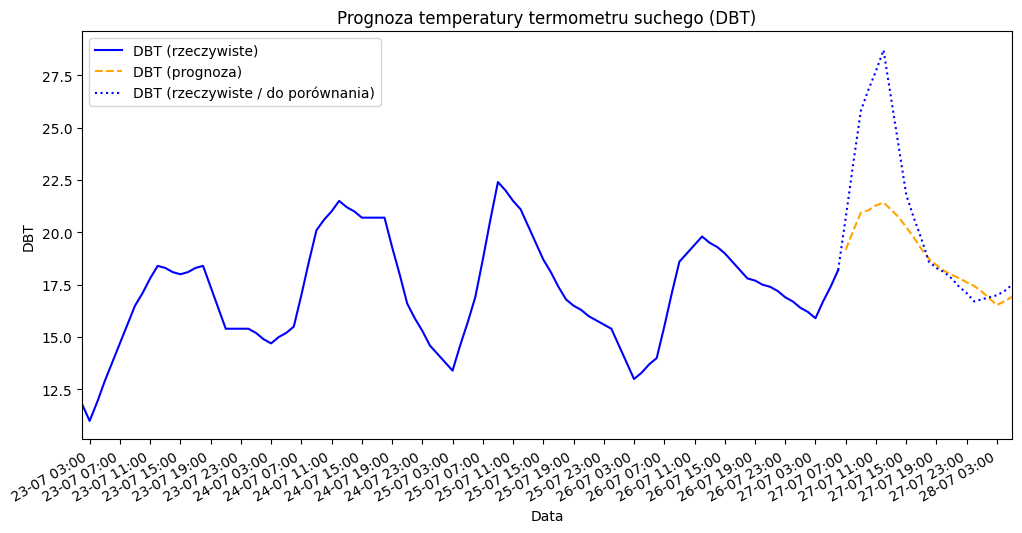

In [169]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['DBT'].values[-100 - n_hours:-n_hours+1], label='DBT (rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['DBT'], label='DBT (prognoza)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours:], df['DBT'].values[-n_hours:], label='DBT (rzeczywiste / do porównania)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title('Prognoza temperatury termometru suchego (DBT)')
plt.xlabel('Data')
plt.ylabel('DBT')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

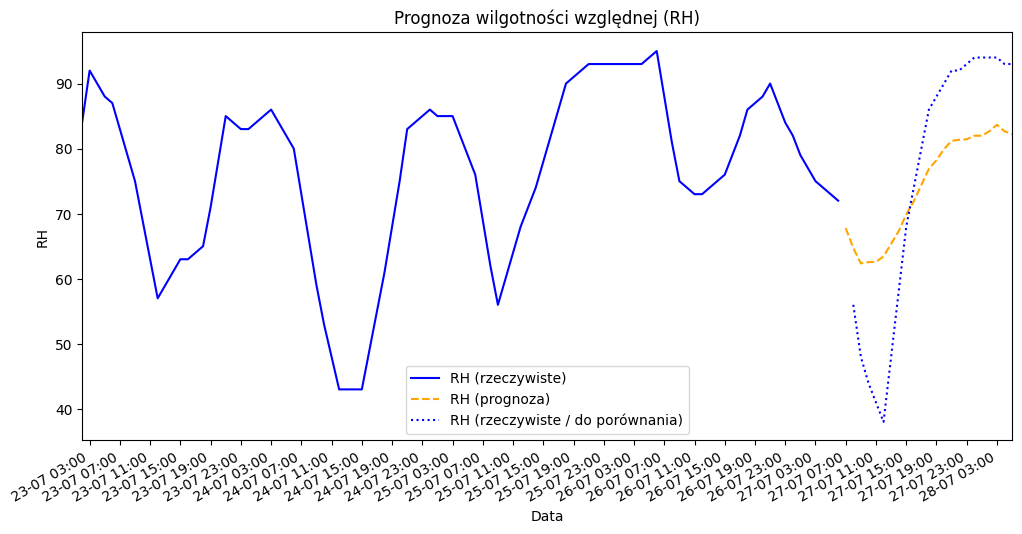

In [170]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['RH'].values[-100 - n_hours:-n_hours+1], label='RH (rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['RH'], label='RH (prognoza)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours+2:], df['RH'].values[-n_hours+2:], label='RH (rzeczywiste / do porównania)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title('Prognoza wilgotności względnej (RH)')
plt.xlabel('Data')
plt.ylabel('RH')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

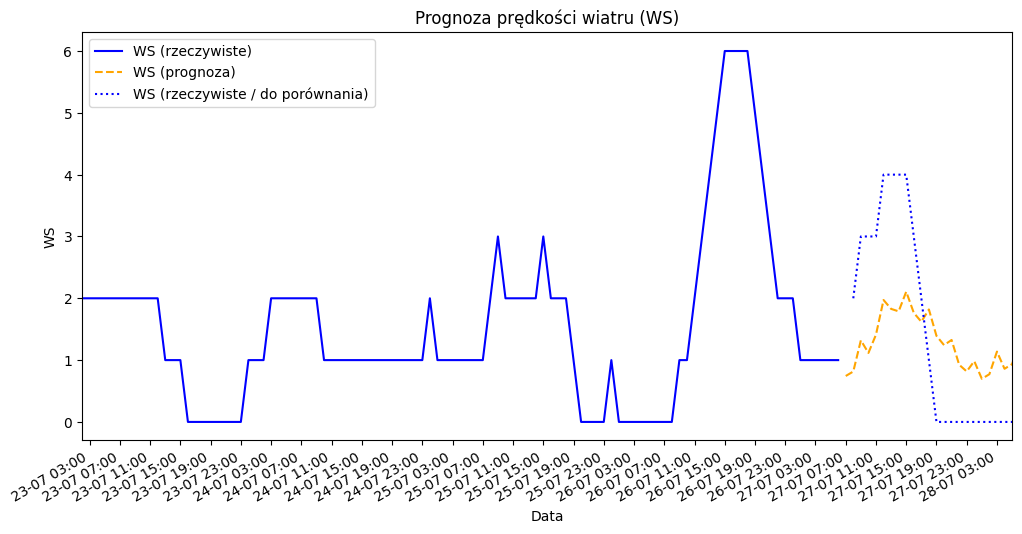

In [171]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['WS'].values[-100 - n_hours:-n_hours+1], label='WS (rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['WS'], label='WS (prognoza)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours+2:], df['WS'].values[-n_hours+2:], label='WS (rzeczywiste / do porównania)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title('Prognoza prędkości wiatru (WS)')
plt.xlabel('Data')
plt.ylabel('WS')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()